# encoder for `SEDflow`

In [1]:
import os, sys
import numpy as np

import torch

In [2]:
sys.path.append('spectrum-encoder/')
from model import *

In [3]:
import corner as DFM 
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
device = torch.device(type='cuda', index=0)

## 1. read SDSS spectra

In [5]:
fsdss = '/scratch/network/chhahn/sedflow/spectra/sdss_spectra.100000.npz'

In [6]:
#data = load_data(fsdss, which="train", device=device)
test_data = load_data(fsdss, which="test", device=device)

Loading 14883 spectra (which = test)


In [7]:
# remove z > 0.2
zlim = (test_data['z'] < 0.2)
test_data['y'] = test_data['y'][zlim]
test_data['w'] = test_data['w'][zlim]
test_data['z'] = test_data['z'][zlim]
test_data['norm'] = torch.tensor(test_data['norm']).to(device)[zlim]

In [8]:
batch_size = 512
testloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(test_data['y'], test_data['w'], test_data['z']),
    batch_size=batch_size)

In [9]:
# define SDSS instrument
wave_obs = torch.tensor(np.load('spectrum-encoder/wave_sdss.npy'))
sdss = Instrument(wave_obs.to(device))

In [10]:
# mask out some of the major lines OII, Hbeta, OIII, Halpha
w_lines = np.array([1033.3  , 1215.67 , 1239.42 , 1305.53 , 1335.52 , 1399.8  ,
       1545.86 , 1640.4  , 1665.85 , 1857.4  , 1908.27 , 2326.   ,
       2439.5  , 2800.32 , 3346.79 , 3426.85 , 3728.3  , 3798.976,
       3836.47 , 3889.   , 3934.777, 3969.588, 4072.3  , 4102.89 ,
       4305.61 , 4341.68 , 4364.436, 4862.68 , 4960.295, 5008.24 ,
       5176.7  , 5895.6  , 6302.046, 6365.536, 6549.86 , 6564.61 ,
       6585.27 , 6707.89 , 6718.29 , 6732.67 ])

emline_mask = np.zeros(test_data['w'].shape).astype(bool) 

for i in range(emline_mask.shape[0]): 
    wls = w_lines * (1. + test_data['z'][i].cpu().numpy())
    for wl in wls: 
        emline_mask[i] = emline_mask[i] | ((wave_obs.cpu().numpy() > wl - 20) & (wave_obs.cpu().numpy() < wl + 20))

In [11]:
test_data['w'][emline_mask] = 1e-6

In [15]:
# restframe wavelength for reconstructed spectra
wave_rest = torch.tensor(np.load('spectrum-encoder/wave_rest.npy'))

print ("Observed frame:\t{:.0f} .. {:.0f} A ({} bins)".format(wave_obs.min(), wave_obs.max(), len(wave_obs)))
print ("Restframe:\t{:.0f} .. {:.0f} A ({} bins)".format(wave_rest.min(), wave_rest.max(), len(wave_rest)))

Observed frame:	3784 .. 9270 A (3892 bins)
Restframe:	3154 .. 9270 A (4670 bins)


In [16]:
best_model = torch.load('spectrum-encoder/sedflow.specoder.emline_mask.0.pt')
best_model.to(device)

SpectrumAutoencoder(
  (encoder): SpectrumEncoder(
    (conv1): Sequential(
      (0): Conv1d(1, 128, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): PReLU(num_parameters=128)
      (3): Dropout(p=0, inplace=False)
    )
    (conv2): Sequential(
      (0): Conv1d(128, 256, kernel_size=(11,), stride=(1,), padding=(5,))
      (1): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): PReLU(num_parameters=256)
      (3): Dropout(p=0, inplace=False)
    )
    (conv3): Sequential(
      (0): Conv1d(256, 512, kernel_size=(21,), stride=(1,), padding=(10,))
      (1): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): PReLU(num_parameters=512)
      (3): Dropout(p=0, inplace=False)
    )
    (conv1w): Sequential(
      (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): InstanceNo

# test reconstruction

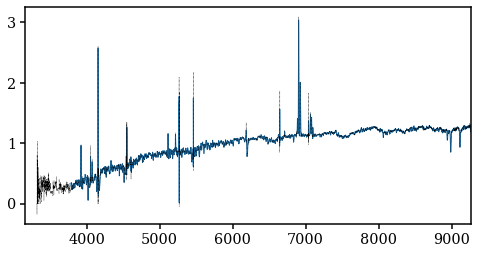

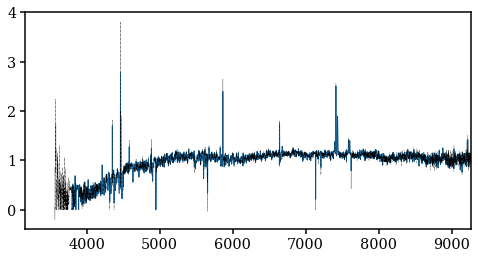

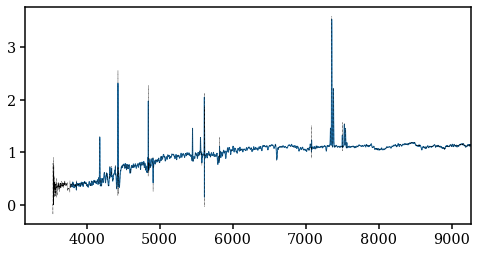

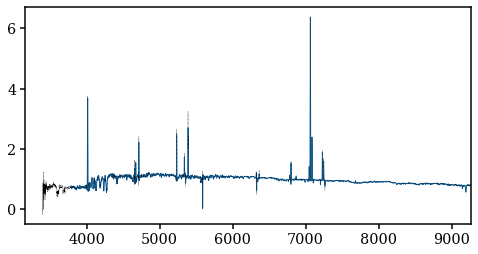

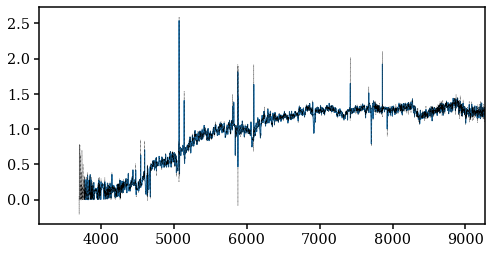

In [17]:
for i in np.arange(5)*100: 
    s, f_rest, f_obs = best_model._forward(test_data['y'][i:i+1], test_data['w'][i:i+1], instrument=sdss, z=test_data['z'][i:i+1])
    
    fig = plt.figure(figsize=(8,4))
    sub = fig.add_subplot(111)
    sub.plot(wave_obs.detach().cpu(), f_obs.detach().cpu().flatten(), lw=1)
    sub.plot((wave_rest.to(device) * (1. + test_data['z'][i])).detach().cpu().flatten(), f_rest.detach().cpu().flatten(), c='k', lw=0.5, ls=':')
    sub.set_xlim(wave_rest.detach().cpu()[0], wave_rest.detach().cpu()[-1])
    plt.show()

# Check out latent variable space of SDSS test data

In [18]:
with torch.no_grad():
    best_model.eval()
        
    s_test = [] 
    for batch in testloader:
        spec, w, z = batch
        s, _, _ = best_model._forward(spec, w, instrument=sdss, z=z)
        s_test.append(s.detach().cpu())
s_test = np.concatenate(s_test, axis=0)

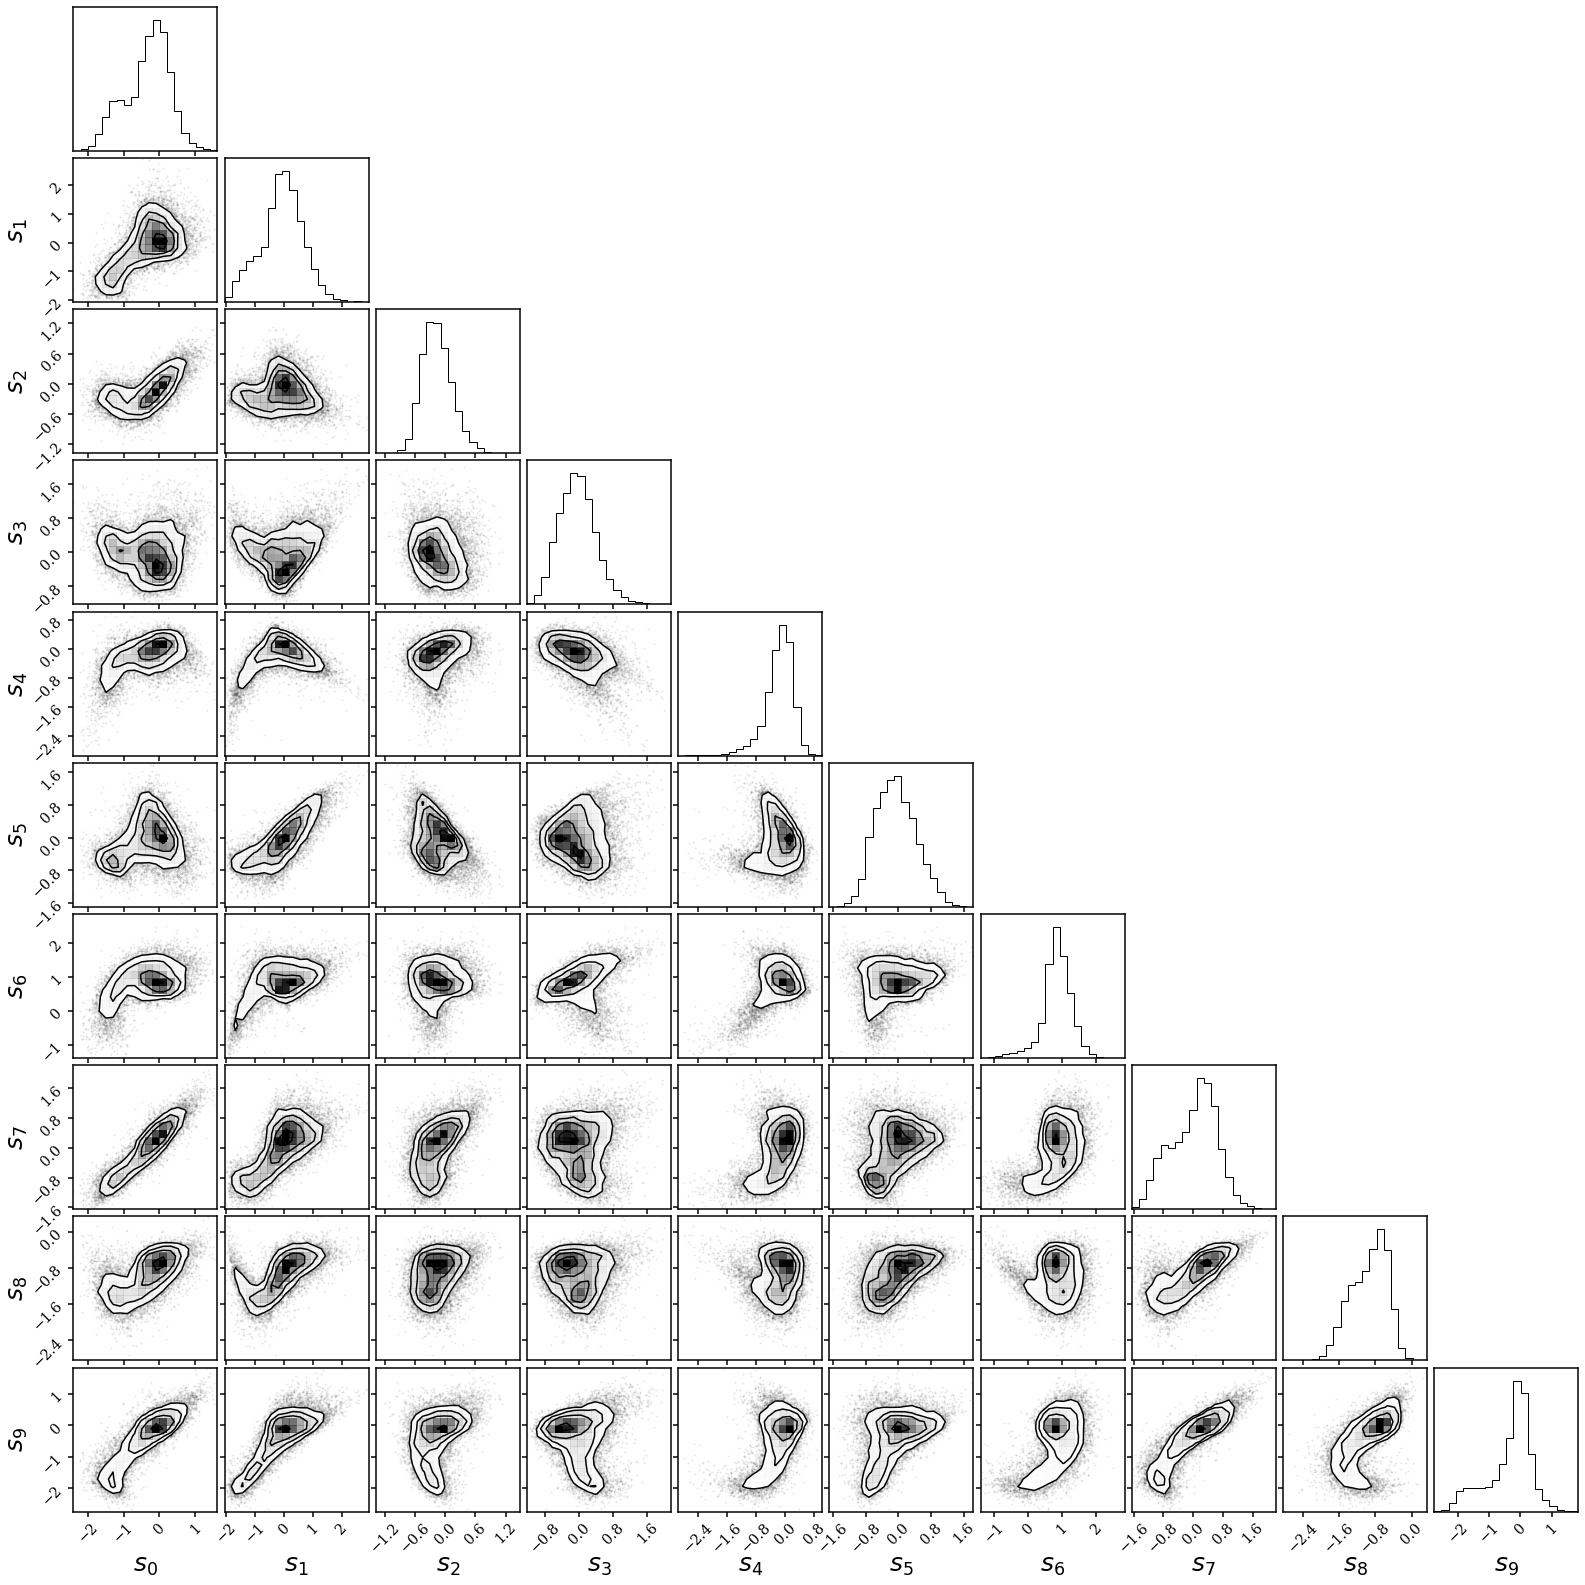

In [19]:
fig = DFM.corner(s_test, 
                 labels=[r'$s_%i$' % i for i in range(s_test.shape[1])], 
                 label_kwargs={'fontsize': 25})

# encode noisy training SEDs

In [20]:
train_seds = np.load('/scratch/network/chhahn/sedflow/training_sed/train.v0.1.0.seds.vae_noise.npy').astype(np.float32)
train_ivar = np.load('/scratch/network/chhahn/sedflow/training_sed/train.v0.1.0.ivar.vae_noise.npy').astype(np.float32)

In [21]:
train_mask = ~np.isfinite(train_seds)

In [22]:
train_seds[train_mask] = 0.

In [23]:
train_norm = get_norm(train_seds)
train_norm = torch.Tensor(train_norm).to(device)

train_w = torch.tensor(train_ivar * ~train_mask * (train_norm**2)[:,None]).to(device)
train_y = torch.tensor(train_seds / train_norm[:, None]).to(device)
train_z = torch.tensor(np.load('/scratch/network/chhahn/sedflow/training_sed/train.v0.1.0.redshifts.npy')).to(device)

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


(0.0, 20.0)

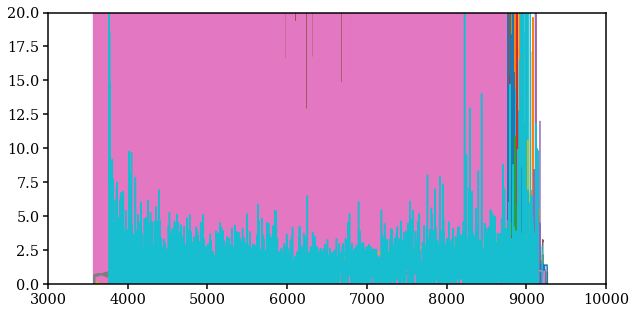

In [24]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for y, z in zip(train_y.detach().cpu().numpy()[::1000], train_z.detach().cpu().numpy()[::1000]): 
    sub.plot(wave_obs / (1 + z), y)
sub.set_xlim(3e3, 1e4)
sub.set_ylim(0., 20.)

In [25]:
# mask out some of the major lines OII, Hbeta, OIII, Halpha
emline_mask_train = np.zeros(train_w.shape).astype(bool) 

for i in range(emline_mask_train.shape[0]): 
    wls = w_lines * (1. + train_z[i].cpu().numpy())
    for wl in wls: 
        emline_mask_train[i] = emline_mask_train[i] | ((wave_obs.cpu().numpy() > wl - 40) & (wave_obs.cpu().numpy() < wl + 40))

In [26]:
train_w[emline_mask_train] = 1e-6
train_w = train_w.clip(1e-6, None)

In [27]:
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_y, train_w, train_z), 
    batch_size=batch_size)

tensor([[-0.9672, -0.8544, -0.2144,  0.0202, -0.3529, -0.5291, -0.9115, -0.4994,
         -0.8059, -1.0889]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[0.7360, 0.6975, 0.8047,  ..., 0.6271, 0.8561, 0.5738]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[ 0.0187, -0.1604,  0.9140,  ...,  0.0373,  0.0181,  0.0216]],
       device='cuda:0', grad_fn=<LeakyReluBackward0>)


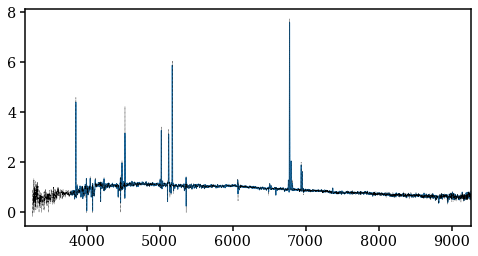

tensor([[-0.9644, -0.6594, -0.0519, -0.4234, -0.3642, -0.0693,  1.0398, -0.7721,
         -1.5244, -0.8485]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[0.5729, 0.5947, 0.5992,  ..., 0.9142, 0.8681, 0.8859]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[ 0.0130, -0.1781,  0.9003,  ...,  0.0394,  0.0072,  0.0070]],
       device='cuda:0', grad_fn=<LeakyReluBackward0>)


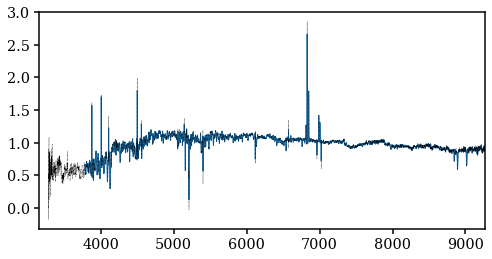

tensor([[ 1.4024,  0.5686,  0.5371,  0.7756, -1.2459, -0.2179,  0.4223,  1.7778,
         -0.0393,  1.6825]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[0.2507, 0.2863, 0.1644,  ..., 1.6434, 1.5224, 1.5069]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[ 1.7778e-03, -1.9129e-01,  4.6818e-01,  ...,  2.3084e-02,
          1.0576e-02, -2.5184e-05]], device='cuda:0',
       grad_fn=<LeakyReluBackward0>)


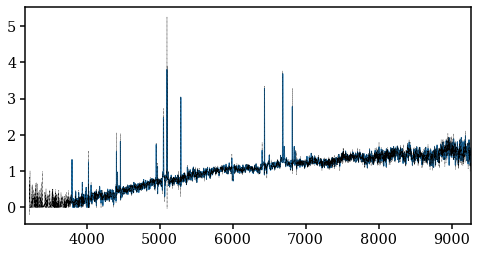

tensor([[-1.4065, -1.1279, -0.2653, -0.2728, -0.8663, -0.1639,  0.9970, -1.1172,
         -1.1948, -1.9408]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[0.6434, 0.6982, 0.6917,  ..., 0.8723, 0.8229, 0.8563]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[ 0.0047, -0.1745,  0.9030,  ...,  0.0289,  0.0036,  0.0012]],
       device='cuda:0', grad_fn=<LeakyReluBackward0>)


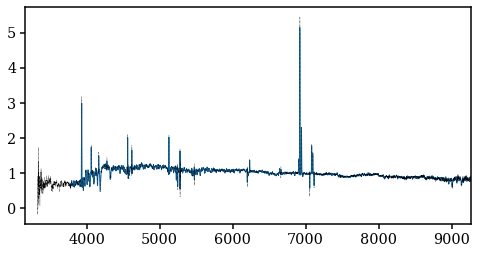

tensor([[-0.6966, -0.9439, -0.3048,  1.1092, -0.7056, -0.6737,  1.0258, -0.6644,
         -1.5559, -0.1540]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[0.7189, 0.6876, 0.6403,  ..., 1.0726, 0.7379, 1.1441]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[-2.1697e-05, -1.7702e-01,  7.2098e-01,  ...,  3.2859e-02,
          2.7523e-02,  1.3424e-02]], device='cuda:0',
       grad_fn=<LeakyReluBackward0>)


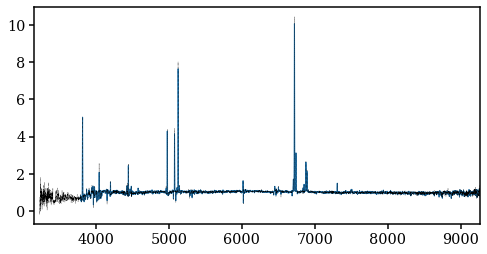

In [28]:
for i in np.arange(5)*100: 
    s, f_rest, f_obs = best_model._forward(train_y[i:i+1], train_w[i:i+1], instrument=sdss, z=train_z[i:i+1])
    print(s)
    print(f_obs)
    print(f_rest)
    fig = plt.figure(figsize=(8,4))
    sub = fig.add_subplot(111)
    sub.plot(wave_obs.detach().cpu(), f_obs.detach().cpu().flatten(), lw=1)
    sub.plot((wave_rest.to(device) * (1. + train_z[i])).detach().cpu().flatten(), f_rest.detach().cpu().flatten(), c='k', lw=0.5, ls=':')
    sub.set_xlim(wave_rest.detach().cpu()[0], wave_rest.detach().cpu()[-1])
    plt.show()

In [29]:
with torch.no_grad():
    best_model.eval()
        
    s_train = [] 
    for batch in train_loader:
        spec, w, z = batch
        s, _, _ = best_model._forward(spec, w, instrument=sdss, z=z)
        s_train.append(s.detach().cpu())
s_train = np.concatenate(s_train, axis=0)

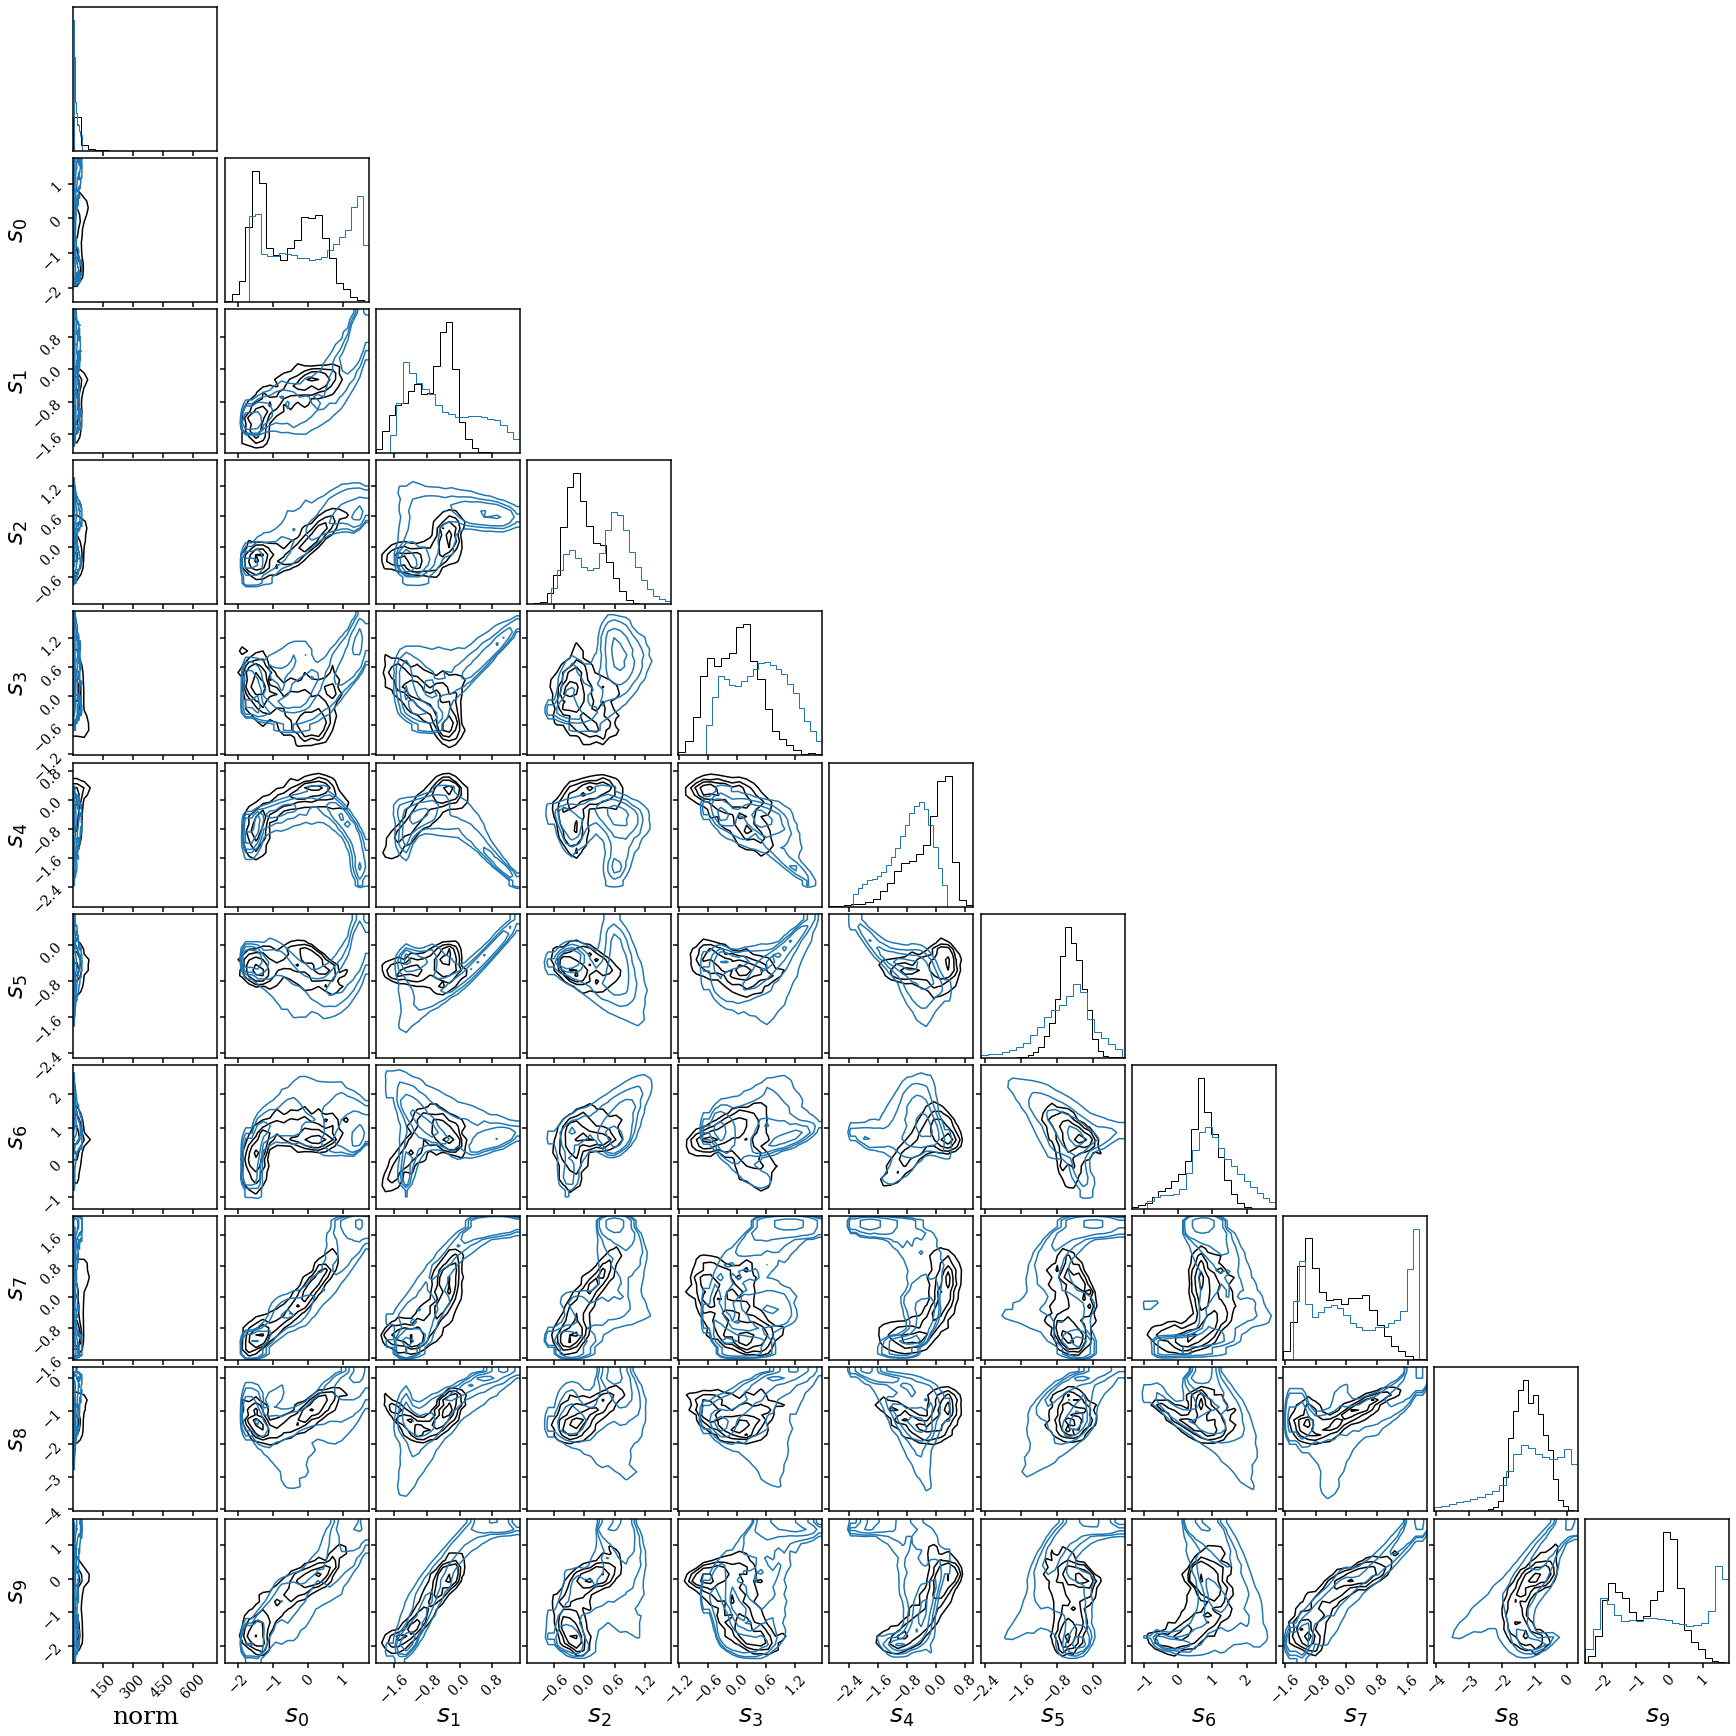

In [67]:
fig = DFM.corner(np.concatenate([test_data['norm'].cpu()[test_data['z'].cpu() < 0.06,None], s_test[test_data['z'].cpu() < 0.06]], axis=1), color='k',
                 hist_kwargs={'density': True}, 
                 plot_density=False, plot_datapoints=False, 
                 labels=['norm'] + [r'$s_%i$' % i for i in range(s_test.shape[1])], 
                 label_kwargs={'fontsize': 25})
_ = DFM.corner(np.concatenate([train_norm.cpu()[:,None], s_train], axis=1), color='C0',
               hist_kwargs={'density': True}, 
               plot_density=False, plot_datapoints=False, 
               range = [np.nanquantile(test_data['norm'].cpu(), [0.01, 0.95])] + [np.nanquantile(_s, [0.01, 0.99]) for _s in s_train.T],
               labels=['norm']+[r'$s_%i$' % i for i in range(s_test.shape[1])], label_kwargs={'fontsize': 25},
               fig=fig)

In [83]:
np.save('/scratch/network/chhahn/sedflow/training_sed/train.v0.1.0.latvar.vae_noise.npy', s_train)
np.save('/scratch/network/chhahn/sedflow/training_sed/train.v0.1.0.norm.vae_noise.npy', train_norm.cpu().detach().numpy())

# lets look at non-overlapping regions

In [31]:
nonoverlap0 = (s_test[:,1] < -1.6)
print(np.sum(nonoverlap0))

329


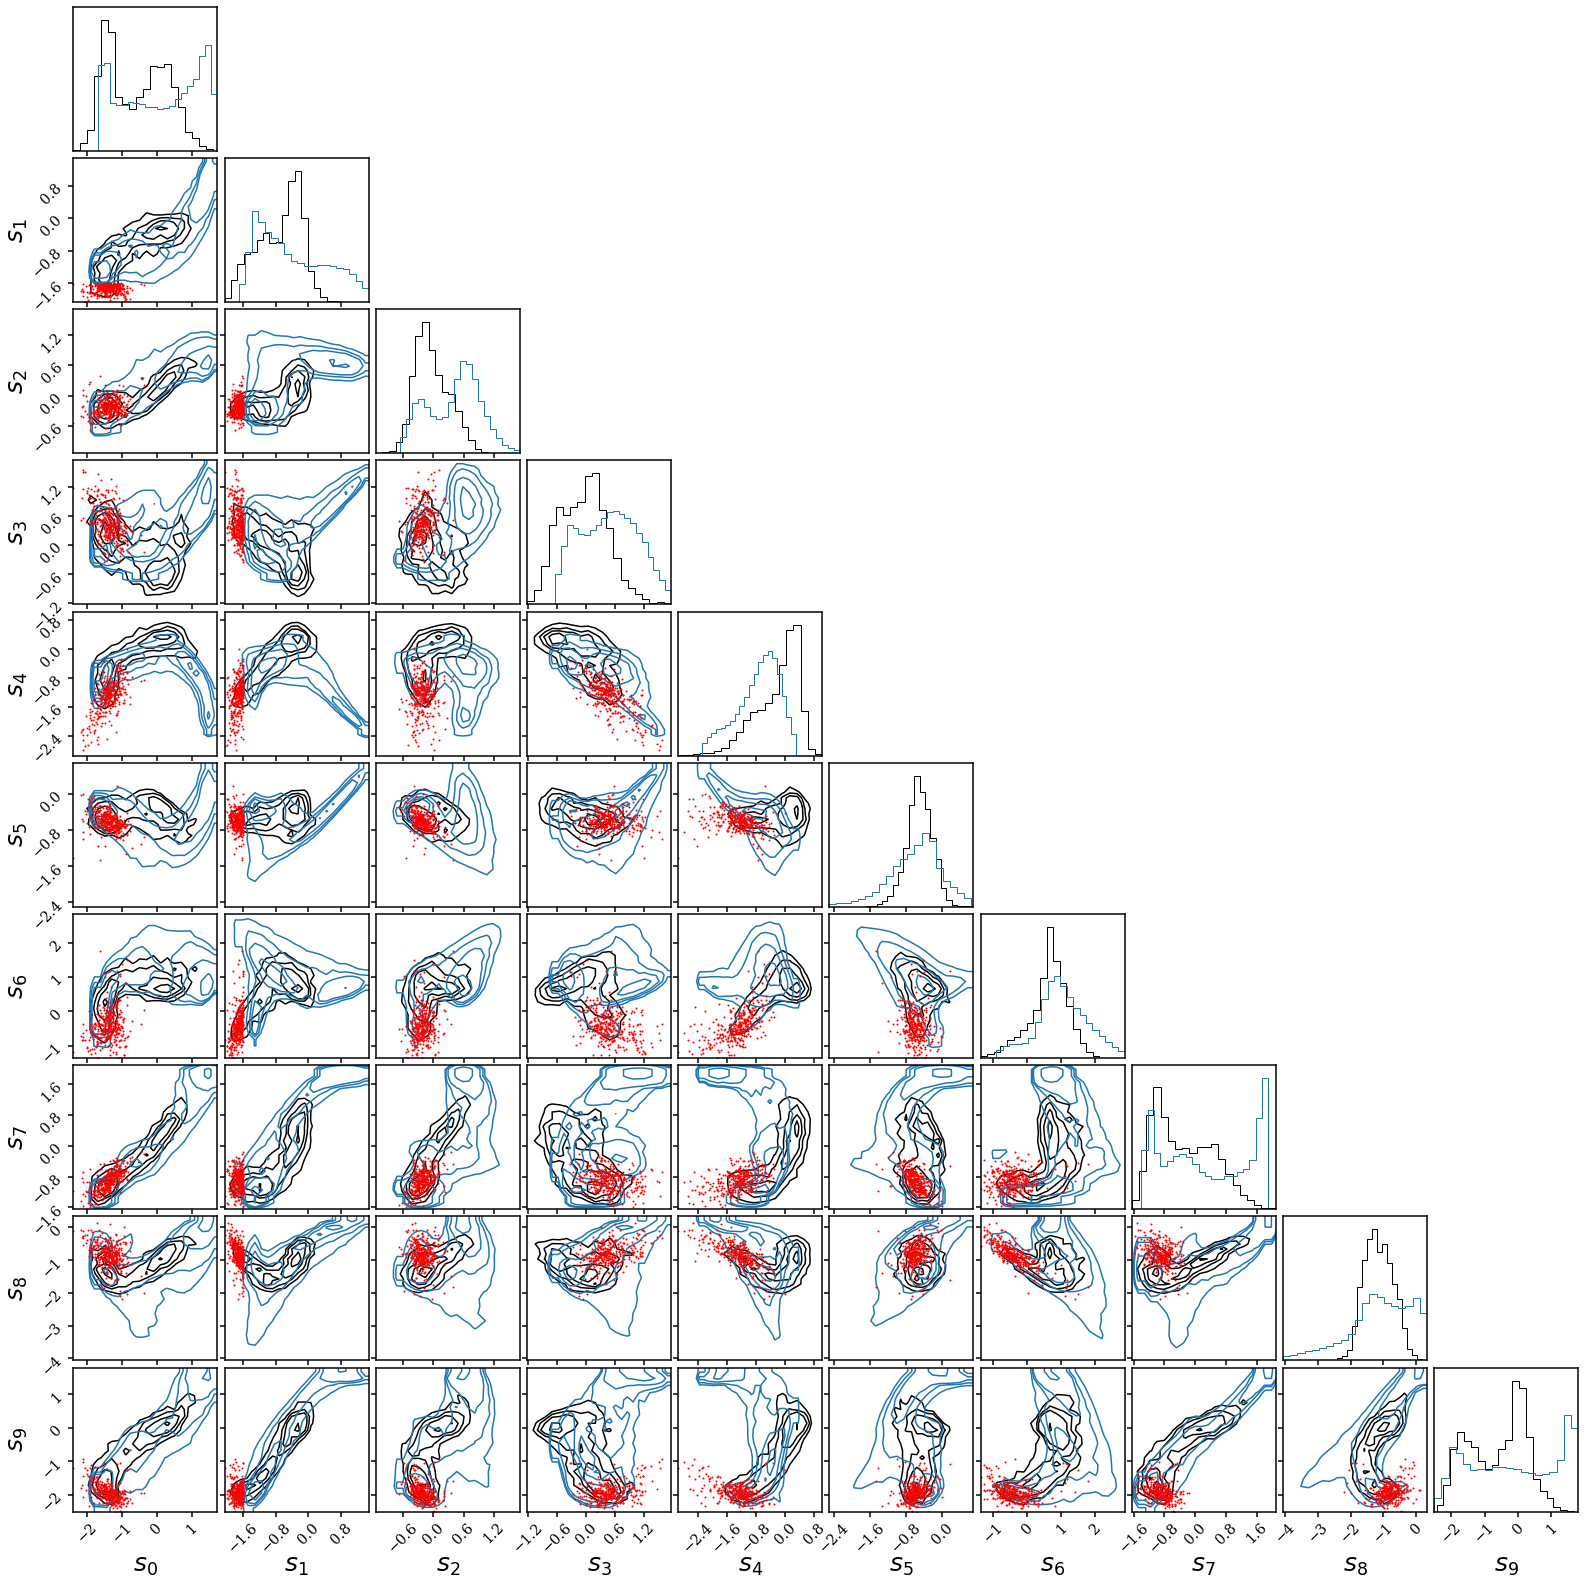

In [32]:
fig = DFM.corner(s_test[test_data['z'].cpu() < 0.06], color='k',
                 hist_kwargs={'density': True}, 
                 plot_density=False, plot_datapoints=False, 
                 labels=[r'$s_%i$' % i for i in range(s_test.shape[1])], 
                 label_kwargs={'fontsize': 25})
_ = DFM.corner(s_train, color='C0',
               hist_kwargs={'density': True}, 
               plot_density=False, plot_datapoints=False, 
               range = [np.nanquantile(_s, [0.01, 0.99]) for _s in s_train.T],
               labels=[r'$s_%i$' % i for i in range(s_test.shape[1])], label_kwargs={'fontsize': 25},
               fig=fig)
DFM.overplot_points(fig, s_test[nonoverlap0], color='r', markersize=2)

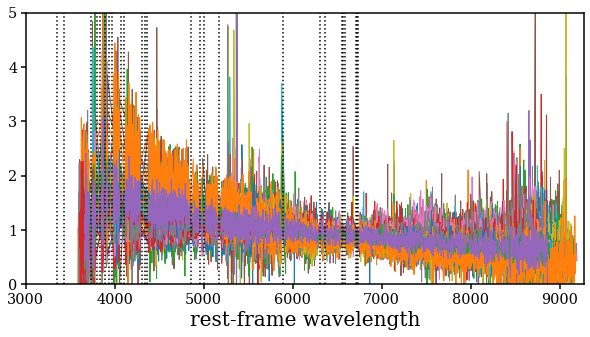

In [35]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for f, w, z in zip(test_data['y'].cpu().detach().numpy()[(test_data['z'].cpu().detach().numpy() < 0.06) & nonoverlap0], 
                   test_data['w'].cpu().detach().numpy()[(test_data['z'].cpu().detach().numpy() < 0.06) & nonoverlap0], 
                   test_data['z'].cpu().detach().numpy()[(test_data['z'].cpu().detach().numpy() < 0.06) & nonoverlap0]): 
    sub.plot((wave_obs / (1. + z))[w > 1e-6], f[w > 1e-6], lw=1)
    
for w in w_lines: 
    sub.axvline(w, color='k', linestyle=':')

sub.set_xlabel('rest-frame wavelength', fontsize=20)
sub.set_xlim(3e3, wave_rest[-1])
sub.set_ylim(0, 5)
plt.show()

In [54]:
nonoverlap1 = (s_test[:,3] < -0.8)

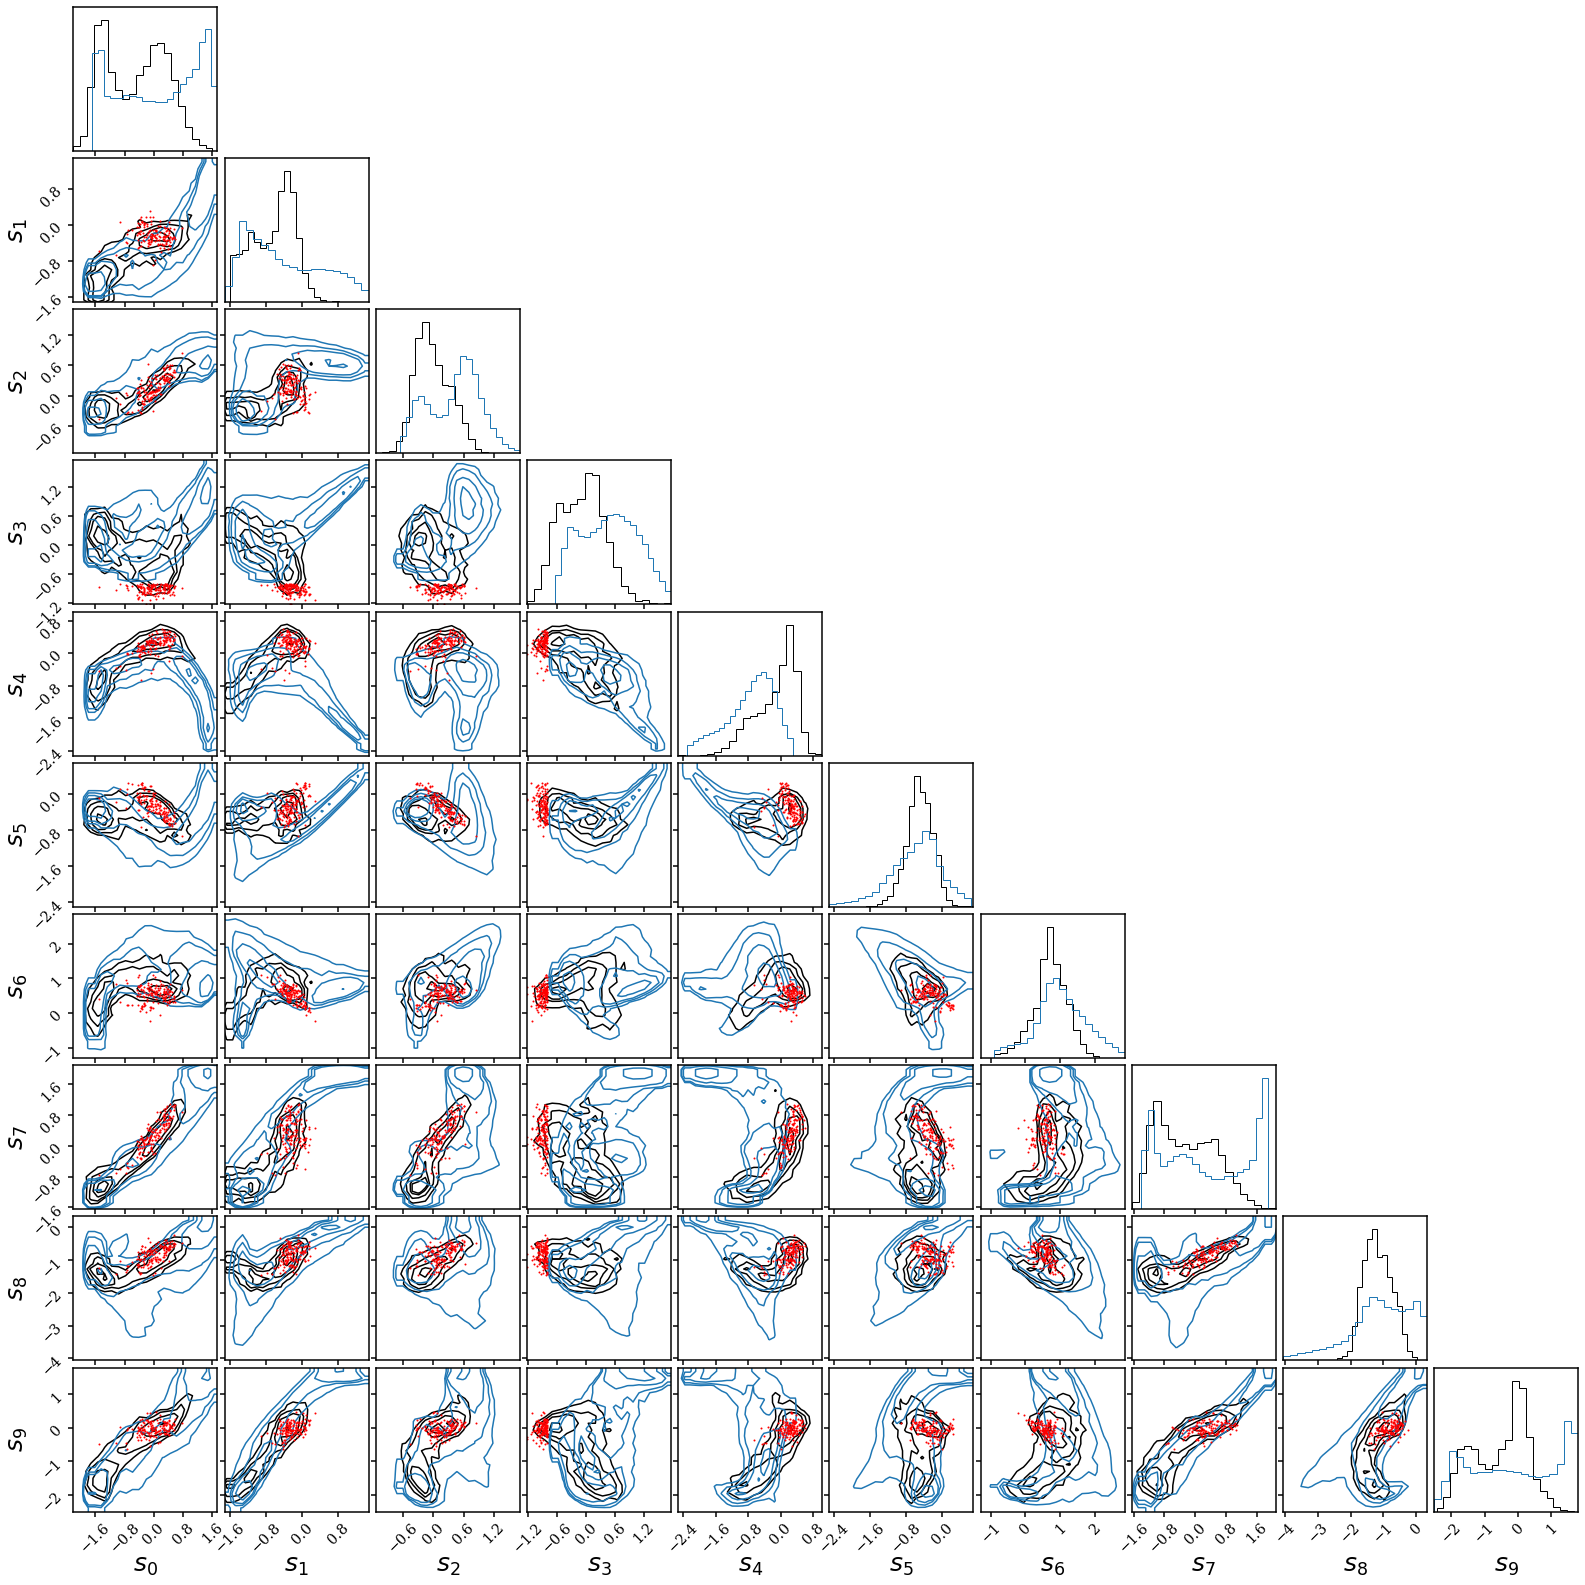

In [55]:
fig = DFM.corner(s_test[(test_data['z'].cpu().detach().numpy() < 0.06) & ~nonoverlap0], color='k',
                 hist_kwargs={'density': True}, 
                 plot_density=False, plot_datapoints=False, 
                 labels=[r'$s_%i$' % i for i in range(s_test.shape[1])], 
                 label_kwargs={'fontsize': 25})
_ = DFM.corner(s_train, color='C0',
               hist_kwargs={'density': True}, 
               plot_density=False, plot_datapoints=False, 
               range = [np.nanquantile(_s, [0.01, 0.99]) for _s in s_train.T],
               labels=[r'$s_%i$' % i for i in range(s_test.shape[1])], label_kwargs={'fontsize': 25},
               fig=fig)
DFM.overplot_points(fig, s_test[(test_data['z'].cpu().detach().numpy() < 0.06) & ~nonoverlap0 & nonoverlap1], color='r', markersize=2)


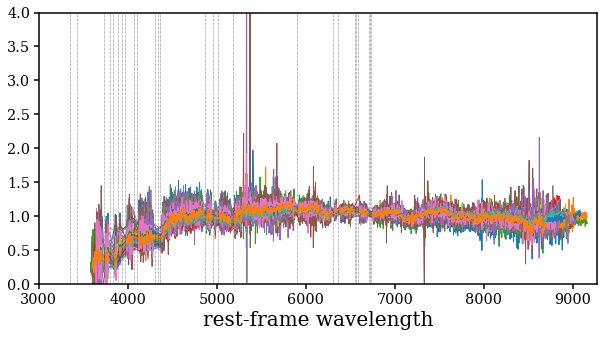

In [56]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for f, w, z in zip(test_data['y'].cpu().detach().numpy()[(test_data['z'].cpu().detach().numpy() < 0.06) & ~nonoverlap0 & nonoverlap1], 
                   test_data['w'].cpu().detach().numpy()[(test_data['z'].cpu().detach().numpy() < 0.06) & ~nonoverlap0 & nonoverlap1], 
                   test_data['z'].cpu().detach().numpy()[(test_data['z'].cpu().detach().numpy() < 0.06) & ~nonoverlap0 & nonoverlap1]): 
    sub.plot((wave_obs / (1. + z))[w > 1e-6], f[w > 1e-6], lw=1)
for w in w_lines: 
    sub.axvline(w, color='k', linestyle=':', linewidth=0.5)
sub.set_xlabel('rest-frame wavelength', fontsize=20)
sub.set_xlim(3e3, wave_rest[-1])
sub.set_ylim(0, 4)
plt.show()

In [47]:
nonoverlap2 = s_test[:,4] > 0.4

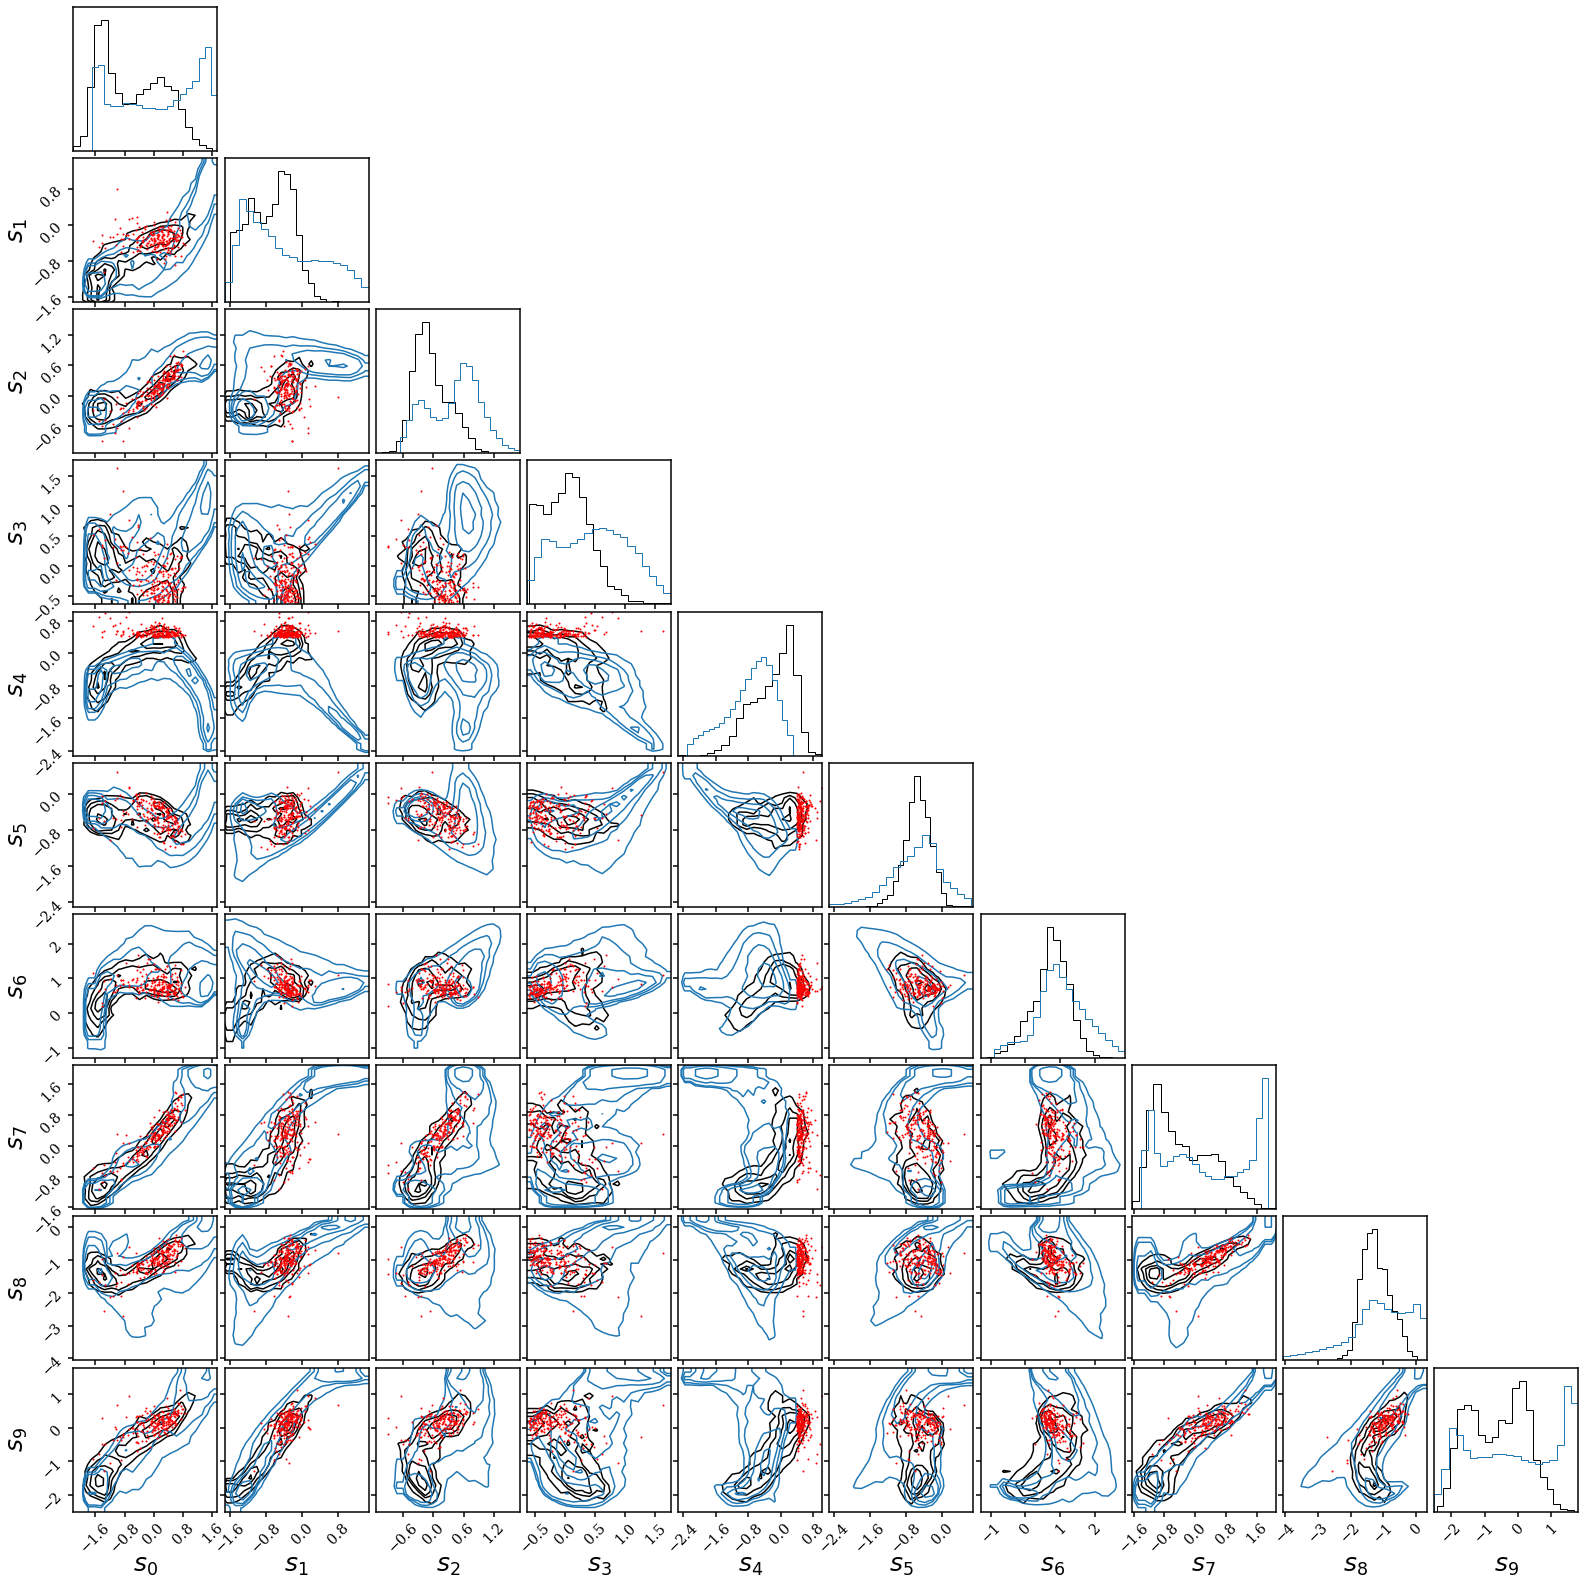

In [48]:
fig = DFM.corner(s_test[(test_data['z'].cpu().detach().numpy() < 0.06) & ~nonoverlap0 & ~nonoverlap1], color='k',
                 hist_kwargs={'density': True}, 
                 plot_density=False, plot_datapoints=False, 
                 labels=[r'$s_%i$' % i for i in range(s_test.shape[1])], 
                 label_kwargs={'fontsize': 25})
_ = DFM.corner(s_train, color='C0',
               hist_kwargs={'density': True}, 
               plot_density=False, plot_datapoints=False, 
               range = [np.nanquantile(_s, [0.01, 0.99]) for _s in s_train.T],
               labels=[r'$s_%i$' % i for i in range(s_test.shape[1])], label_kwargs={'fontsize': 25},
               fig=fig)
DFM.overplot_points(fig, s_test[(test_data['z'].cpu().detach().numpy() < 0.06) & ~nonoverlap0 & ~nonoverlap1 & nonoverlap2], color='r', markersize=2)


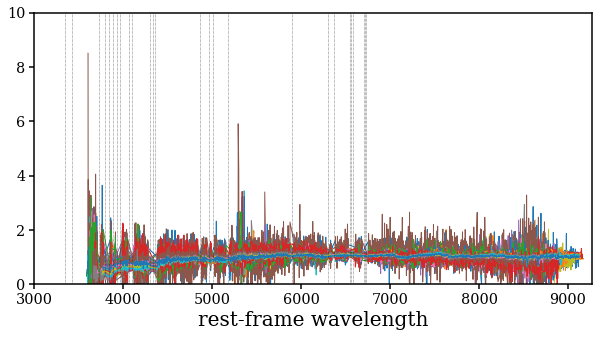

In [50]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for f, w, z in zip(test_data['y'].cpu().detach().numpy()[(test_data['z'].cpu().detach().numpy() < 0.06) & ~nonoverlap0 & ~nonoverlap1 & nonoverlap2], 
                   test_data['w'].cpu().detach().numpy()[(test_data['z'].cpu().detach().numpy() < 0.06) & ~nonoverlap0 & ~nonoverlap1 & nonoverlap2], 
                   test_data['z'].cpu().detach().numpy()[(test_data['z'].cpu().detach().numpy() < 0.06) & ~nonoverlap0 & ~nonoverlap1 & nonoverlap2]): 
    sub.plot((wave_obs / (1. + z))[w > 1e-6], f[w > 1e-6], lw=1)
for w in w_lines: 
    sub.axvline(w, color='k', linestyle=':', linewidth=0.5)

sub.set_xlabel('rest-frame wavelength', fontsize=20)
sub.set_xlim(3e3, wave_rest[-1])
sub.set_ylim(0, 10)
plt.show()

In [53]:
print(np.sum((test_data['z'].cpu().detach().numpy() < 0.06)))
print(np.sum((test_data['z'].cpu().detach().numpy() < 0.06) & (nonoverlap0 | nonoverlap1 | nonoverlap2)))

3068
841
